# Побудова базових ML моделей

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                              accuracy_score, f1_score, precision_score, recall_score)
from scipy.sparse import hstack, csr_matrix

# Завантаження даних:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_PATH = Path('/content/drive/MyDrive/MERGE_Bimodal_Balanced')
PROCESSED_FILE = DATA_PATH / 'processed_data_with_all_features.csv'

TRAIN_FILE = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_train_bimodal_balanced.csv'
VAL_FILE = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_validate_bimodal_balanced.csv'
TEST_FILE = DATA_PATH / 'tvt_dataframes' / 'tvt_70_15_15' / 'tvt_70_15_15_test_bimodal_balanced.csv'

df_full = pd.read_csv(PROCESSED_FILE)

df_train_ids = pd.read_csv(TRAIN_FILE)
df_val_ids = pd.read_csv(VAL_FILE)
df_test_ids = pd.read_csv(TEST_FILE)


df_train = df_full.iloc[df_train_ids.index]
df_val = df_full.iloc[df_val_ids.index]
df_test = df_full.iloc[df_test_ids.index]

train_song_ids = df_train_ids['Song'].values
val_song_ids = df_val_ids['Song'].values
test_song_ids = df_test_ids['Song'].values

df_train = df_full[df_full['Audio_Song'].isin(train_song_ids)].copy()
df_val = df_full[df_full['Audio_Song'].isin(val_song_ids)].copy()
df_test = df_full[df_full['Audio_Song'].isin(test_song_ids)].copy()

train_songs = set(df_train['Audio_Song'].values)
val_songs = set(df_val['Audio_Song'].values)
test_songs = set(df_test['Audio_Song'].values)

overlap = train_songs & val_songs & test_songs


Mounted at /content/drive


# Підготовка features:

In [ ]:
tfidf_file = DATA_PATH / 'tfidf_matrix.pkl'
with open(tfidf_file, 'rb') as f:
    tfidf_data = pickle.load(f)
    tfidf_vectorizer = tfidf_data['vectorizer']

X_text_train = tfidf_vectorizer.transform(df_train['lyrics_processed'].fillna(''))
X_text_val = tfidf_vectorizer.transform(df_val['lyrics_processed'].fillna(''))
X_text_test = tfidf_vectorizer.transform(df_test['lyrics_processed'].fillna(''))

print(f"\nText features: {X_text_train.shape[1]} ознак")

audio_feature_cols = [col for col in df_full.columns if any(
    prefix in col for prefix in ['mfcc', 'chroma', 'spectral', 'tempo',
                                   'zcr', 'rms', 'harmonic', 'percussive', 'mel']
)]

X_audio_train = df_train[audio_feature_cols].fillna(0).values
X_audio_val = df_val[audio_feature_cols].fillna(0).values
X_audio_test = df_test[audio_feature_cols].fillna(0).values

print(f"Audio features: {len(audio_feature_cols)} ознак")
scaler_audio = StandardScaler()
X_audio_train_scaled = scaler_audio.fit_transform(X_audio_train)
X_audio_val_scaled = scaler_audio.transform(X_audio_val)
X_audio_test_scaled = scaler_audio.transform(X_audio_test)

X_combined_train = hstack([X_text_train, csr_matrix(X_audio_train_scaled)])
X_combined_val = hstack([X_text_val, csr_matrix(X_audio_val_scaled)])
X_combined_test = hstack([X_text_test, csr_matrix(X_audio_test_scaled)])

print(f"Combined features: {X_combined_train.shape[1]} ознак")

y_train = df_train['emotion_quadrant'].values
y_val = df_val['emotion_quadrant'].values
y_test = df_test['emotion_quadrant'].values

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)


Text features: 5000 ознак
Audio features: 43 ознак
Combined features: 5043 ознак


# BASELINE MODELS (TEXT ONLY):

In [ ]:
models_text = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'SVM': SVC(kernel='linear', C=0.1, probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_split=10,
        min_samples_leaf=4, max_features='sqrt', random_state=42
    )
}

results_text = {}

for name, model in models_text.items():
    print(f"\nНавчання {name}")
    model.fit(X_text_train, y_train)
    y_val_pred = model.predict(X_text_val)

    results_text[name] = {
        'model': model,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred, average='weighted'),
        'precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_val, y_val_pred, average='weighted'),
        'predictions': y_val_pred
    }

    print(f"  Val Accuracy: {results_text[name]['accuracy']:.4f}")
    print(f"  Val F1-Score: {results_text[name]['f1']:.4f}")


Навчання Logistic Regression
  Val Accuracy: 0.6167
  Val F1-Score: 0.6165

Навчання KNN
  Val Accuracy: 0.4900
  Val F1-Score: 0.4881

Навчання SVM
  Val Accuracy: 0.5333
  Val F1-Score: 0.5365

Навчання Random Forest
  Val Accuracy: 0.5600
  Val F1-Score: 0.5593


# BASELINE MODELS (AUDIO ONLY)

In [ ]:
models_audio = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=0.5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=9),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=10,
        min_samples_leaf=4, random_state=42
    )
}

results_audio = {}

for name, model in models_audio.items():
    print(f"\nНавчання {name}")
    model.fit(X_audio_train_scaled, y_train)
    y_val_pred = model.predict(X_audio_val_scaled)

    results_audio[name] = {
        'model': model,
        'accuracy': accuracy_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred, average='weighted'),
        'precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_val, y_val_pred, average='weighted'),
        'predictions': y_val_pred
    }

    print(f"  Val Accuracy: {results_audio[name]['accuracy']:.4f}")
    print(f"  Val F1-Score: {results_audio[name]['f1']:.4f}")



Навчання Logistic Regression
  Val Accuracy: 0.6333
  Val F1-Score: 0.6306

Навчання KNN
  Val Accuracy: 0.5867
  Val F1-Score: 0.5851

Навчання SVM
  Val Accuracy: 0.6400
  Val F1-Score: 0.6367

Навчання Random Forest
  Val Accuracy: 0.5900
  Val F1-Score: 0.5882


# MULTIMODAL MODELS - (TEXT + AUDIO)

In [ ]:
models_combined = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=0.5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=9),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=8,
        max_features='sqrt',
        random_state=42
    )
}

results_combined = {}

for name, model in models_combined.items():
    print(f"\nНавчання {name}...")

    model.fit(X_combined_train, y_train)
    y_val_pred = model.predict(X_combined_val)

    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_val_pred, average='weighted')

    results_combined[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_val_pred
    }

    print(f"     Accuracy:  {accuracy:.4f}")
    print(f"     F1-score:  {f1:.4f}")


Навчання Logistic Regression...
     Accuracy:  0.6667
     F1-score:  0.6633

Навчання KNN...
     Accuracy:  0.5900
     F1-score:  0.5886

Навчання SVM...
     Accuracy:  0.6433
     F1-score:  0.6397

Навчання Random Forest...
     Accuracy:  0.6367
     F1-score:  0.6340


# Validation

    Approach          Best Model  F1-Score  Accuracy
   Text-only Logistic Regression  0.616460  0.616667
  Audio-only                 SVM  0.636741  0.640000
Text + Audio Logistic Regression  0.663261  0.666667


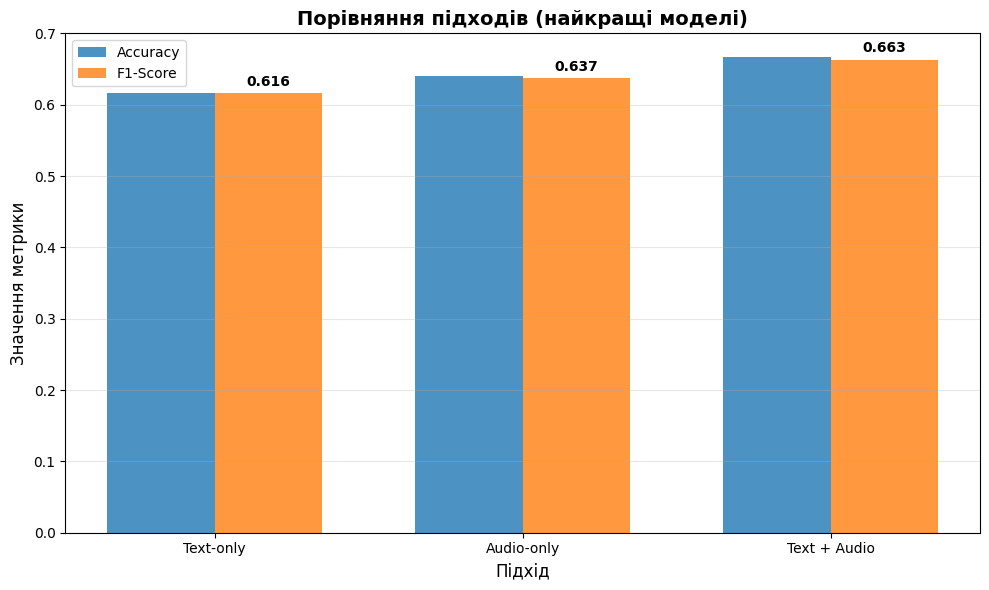

In [ ]:
best_text = max(results_text.items(), key=lambda x: x[1]['f1'])
best_audio = max(results_audio.items(), key=lambda x: x[1]['f1'])
best_combined = max(results_combined.items(), key=lambda x: x[1]['f1'])

comparison_df = pd.DataFrame({
    'Approach': ['Text-only', 'Audio-only', 'Text + Audio'],
    'Best Model': [best_text[0], best_audio[0], best_combined[0]],
    'F1-Score': [best_text[1]['f1'], best_audio[1]['f1'], best_combined[1]['f1']],
    'Accuracy': [best_text[1]['accuracy'], best_audio[1]['accuracy'], best_combined[1]['accuracy']]
})

print(comparison_df.to_string(index=False))
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax.bar(x + width/2, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Підхід', fontsize=12)
ax.set_ylabel('Значення метрики', fontsize=12)
ax.set_title('Порівняння підходів (найкращі моделі)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Approach'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_df['F1-Score']):
    ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Оцінка на TEST SET:


Text-only (Logistic Regression):
   Accuracy: 0.7000
   F1-Score: 0.6989

Audio-only (SVM):
   Accuracy: 0.6267
   F1-Score: 0.6244

Combined (Logistic Regression):
   Accuracy: 0.6933
   F1-Score: 0.6948


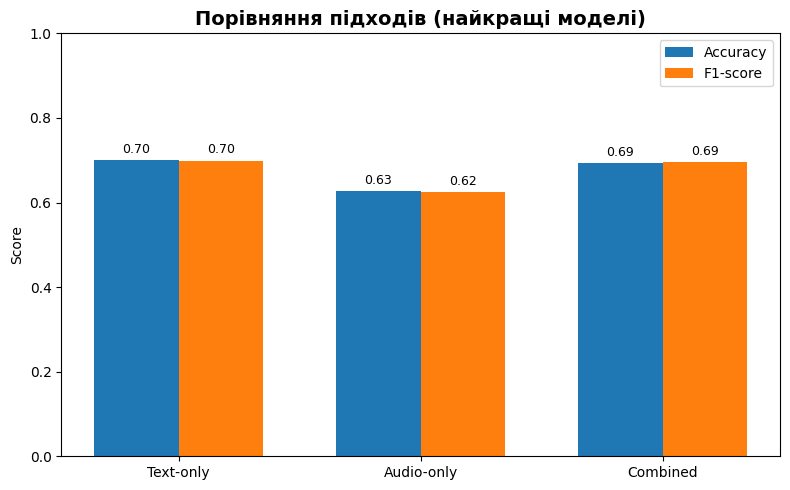

In [ ]:
print(f"\nText-only ({best_text[0]}):")
y_test_pred_text = best_text[1]['model'].predict(X_text_test)
test_acc_text = accuracy_score(y_test, y_test_pred_text)
test_f1_text = f1_score(y_test, y_test_pred_text, average='weighted')
print(f"   Accuracy: {test_acc_text:.4f}")
print(f"   F1-Score: {test_f1_text:.4f}")

print(f"\nAudio-only ({best_audio[0]}):")
y_test_pred_audio = best_audio[1]['model'].predict(X_audio_test_scaled)
test_acc_audio = accuracy_score(y_test, y_test_pred_audio)
test_f1_audio = f1_score(y_test, y_test_pred_audio, average='weighted')
print(f"   Accuracy: {test_acc_audio:.4f}")
print(f"   F1-Score: {test_f1_audio:.4f}")

print(f"\nCombined ({best_combined[0]}):")
y_test_pred_combined = best_combined[1]['model'].predict(X_combined_test)
test_acc_combined = accuracy_score(y_test, y_test_pred_combined)
test_f1_combined = f1_score(y_test, y_test_pred_combined, average='weighted')
print(f"   Accuracy: {test_acc_combined:.4f}")
print(f"   F1-Score: {test_f1_combined:.4f}")
labels = ['Text-only', 'Audio-only', 'Combined']
acc_scores = [test_acc_text, test_acc_audio, test_acc_combined]
f1_scores = [test_f1_text, test_f1_audio, test_f1_combined]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, acc_scores, width, label='Accuracy')
bars2 = plt.bar(x + width/2, f1_scores, width, label='F1-score')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=9)

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title('Порівняння підходів (найкращі моделі)', fontsize=14, fontweight='bold')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()